In [1]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import manipulate_text as mt
import numpy.ma as ma
from scipy import interpolate
from scipy.optimize import fsolve

In [2]:
def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW

def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit

def find_circular_rings(THETA, th_range):
    ind = np.where(np.logical_or(THETA<th_range[0], THETA>th_range[1]))
    return ind

#puts indices in decending order with respect to a certain axis
def sort_ind(ind, axis=0):
    p = ind[0].argsort()[::-1]
    new_ind = ()
    for elem in ind:
        new_ind += (elem[p],)
    return new_ind

def mask_image(image, ind , sort=True):
    sh = image.shape
    #reshape image if neccessary 
    if not len(sh) == 3:
        n = sh[0]
        N = sh[1]
        block_image = np.transpose(image).reshape(N,n)
    else:
        block_image = image

    #convert block_image to a list of arrays
    block_image_ls = list(block_image)
    
    #sort indices if neccesary
    if sort:
        #reorder ind
        ind = sort_ind(ind)
    
    #remove entries
    for i in range(len(ind[0])):
        block_image_ls[ind[1][i]] = np.delete(block_image_ls[ind[1][i]], ind[0][i], 0)
    
    return block_image_ls

#coords = (x, y)                                                                                                                                               
#ellipse_params = (r2, a, thickness/2)                                                                                                                         
def create_mask(THETA, th_range, ps_ind=None, rl=None, coords=None, ellipse_params=None, data=None,  sigma_rms=None, num_sigma_rms=None, sigma_BW=None, num_sigma_BW=None, dlt=None,\
 method='azimuthally_sym'):
    m0 = 0*THETA==0
    m1 = m0
    m2 = m0
    m3 = m0
    if ps_ind is not None:
        m0[ps_ind]=False
    if method=='azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
    elif method=='ellipse_and_azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
        elliptic_d = np.sqrt(coords[0]**2+(ellipse_params[0]**2)*coords[1]**2)
        m2 = np.abs(elliptic_d-ellipse_params[1])>ellipse_params[2]
    if rl=='right':
        m3[np.where(AX_N>=0)] = False
    elif rl=='left':
        m3[np.where(AX_N<=0)] = False
    return m0*m1*m2*m3
    
def make_spot(x, w_spot):
    template = w_spot[2]*np.exp(-((x[0]-w_spot[0])**2+(x[1]-w_spot[1])**2)/(2*w_spot[3]**2))
    return template
    
def f(x, w):
    elliptic_d = np.sqrt(x[0]**2+(w[2]**2)*x[1]**2)
    ell_unif = w[0]+w[1]*np.exp(-(elliptic_d-w[3])**2/(2*w[4]**2))
    res = ell_unif
    return res

def im_to_1d(image, kind='list'):
    if kind=='list':
        image_t = tuple(image)
    res = np.hstack(image_t)
    return res

#args = (data, x, sigma, mask)
def chi2(w, *args):
    model = f(args[1], w)
    return np.sum(((args[0]-model)**2/args[2]**2)*args[3])

def remove_ps(data, THETA, cent, ann1, ann2, thresh):
    #find center index
    ind0 = np.where(THETA==0)
    indy0 = ind0[0][0]
    indx0 = ind0[1][0]

    #find indices of annulus
    ind_ann0 = np.where(np.logical_and(THETA>ann1, THETA<ann2))
    dlt_ind_ann = (ind_ann0[0]-indy0, ind_ann0[1]-indx0)

    #find indices of center
    ind_cent0 = np.where(THETA<cent)
    dlt_ind_cent = (ind_cent0[0]-indy0, ind_cent0[1]-indx0)
    
    #prepare for for-loops
    sh = data.shape
    mask_indx = []
    mask_indy = []
    
    #iterate over each pixel, putting the circle and annulus centered over the pixel and computing the average
    #intensity in each. If the circle has an average intensity larger than the annulus by a certain amount
    #then store the indices of the circle for masking
    for i in range(sh[0]):
        #print('i: ', i)
        for j in range(sh[1]):
            ind_of_ind = [k for k in range(len(dlt_ind_ann[0])) \
                                  if j+dlt_ind_ann[1][k] < N and j+dlt_ind_ann[1][k] >= 0\
                                 and i+dlt_ind_ann[0][k] < n and i+dlt_ind_ann[0][k] >= 0]
            ind_ann_x = [int(j+dlt_ind_ann[1][ind]) for ind in ind_of_ind]
            ind_ann_y = [int(i+dlt_ind_ann[0][ind]) for ind in ind_of_ind]
            num_ann = len(ind_of_ind)

            ind_of_ind_cent = [k for k in range(len(dlt_ind_cent[0])) \
                                  if j+dlt_ind_cent[1][k] < N and j+dlt_ind_cent[1][k] >= 0\
                                 and i+dlt_ind_cent[0][k] < n and i+dlt_ind_cent[0][k] >= 0]
            ind_cent_x = [int(j+dlt_ind_cent[1][ind]) for ind in ind_of_ind_cent]
            ind_cent_y = [int(i+dlt_ind_cent[0][ind]) for ind in ind_of_ind_cent]
            num_cent = len(ind_of_ind_cent)

            #compute average intensity in annulus and center
            I_center = np.sum(data[(ind_cent_y, ind_cent_x)])/num_cent
            I_ann = np.sum(data[(ind_ann_y, ind_ann_x)])/num_ann

            if I_center > thresh[i,j]+I_ann: #or I_center < I_ann-thresh[i,j]: (include if voids should be masked)
                mask_indy += list(ind_cent_y)
                mask_indx += list(ind_cent_x)
                
    #remove repeated pairs of indices from the list of indices
    mask_inds_raw = np.array([mask_indy, mask_indx])
    print('raw indices found')
    mask_inds = np.unique(mask_inds_raw, axis=1)
    
    #plot data with masked indices indicated with scatter points
    plt.imshow(data)
    plt.scatter(mask_inds[1], mask_inds[0], s=2, color='r')
    
    return tuple(mask_inds)

In [51]:
#define relevant paths and names
base_path = os.getcwd().split('scripts')[0]
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'
fig_path = base_path + 'figs/'

In [4]:
#extract info about data
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
print('real data info extracted')

real data info extracted


In [5]:
#create coords for data
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
THETA = np.sqrt(AX_N**2+AX_n**2)
sigma_rms = [0.25, 0.3]
l = 2/3
b = 2/3
outside = np.logical_or(np.abs(AX_N)>(l/2)*np.pi/180, np.abs(AX_n)>(b/2)*np.pi/180)
inside = np.logical_not(outside)
noise = sigma_rms[-1]*outside + sigma_rms[0]*inside
rl_mask = ''

raw indices found


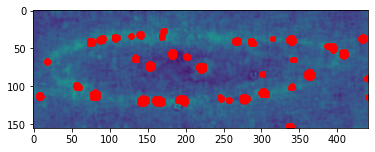

In [6]:
#define dimensionless hyperparams
dless_rad0 = .75
dless_rad1 = 2.25
dless_rad2 = 2.5
num_sigmas = 4

#compute physical hyperparams
cent = dless_rad0*HPBW/2
ann1 = dless_rad1*HPBW/2
ann2 = dless_rad2*HPBW/2
thresh = num_sigmas*noise

mask_inds = remove_ps(data, THETA, cent, ann1, ann2, thresh)

0.0011865336088032082
[0.000e+00 1.000e+00 3.300e+01 1.170e+02 1.440e+02 1.880e+02 2.360e+02
 2.480e+02 2.740e+02 3.200e+02 3.570e+02 3.570e+02 4.330e+02 4.560e+02
 4.920e+02 5.390e+02 5.530e+02 5.450e+02 6.040e+02 5.890e+02 6.270e+02
 7.120e+02 7.230e+02 7.530e+02 8.520e+02 8.230e+02 8.310e+02 9.100e+02
 8.630e+02 8.980e+02 9.670e+02 9.750e+02 1.039e+03 1.078e+03 9.410e+02
 8.750e+02 8.310e+02 8.310e+02 7.730e+02 8.100e+02 8.130e+02 8.240e+02
 8.310e+02 7.940e+02 7.930e+02 8.160e+02 7.840e+02 8.160e+02 7.980e+02
 7.920e+02 7.500e+02 7.400e+02 7.090e+02 7.050e+02 7.730e+02 7.430e+02
 7.680e+02 7.610e+02 7.160e+02 6.900e+02 6.890e+02 6.930e+02 6.940e+02
 7.010e+02 7.260e+02 7.280e+02 7.660e+02 7.720e+02 7.270e+02 7.300e+02
 7.460e+02 7.060e+02 7.450e+02 7.320e+02 7.080e+02 7.440e+02 7.180e+02
 7.290e+02 7.590e+02 7.250e+02 7.060e+02 7.340e+02 7.130e+02 7.360e+02
 7.420e+02 7.440e+02 7.140e+02 7.320e+02 7.390e+02 7.360e+02 7.350e+02
 7.070e+02 6.930e+02 6.910e+02 6.430e+02 4.480e+02 3.16

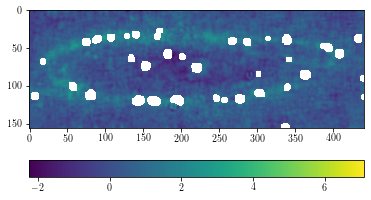

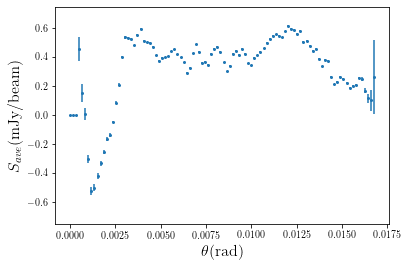

In [8]:
omega_pix = dlt_N*dlt_n
pix_per_beam = omega_beam/omega_pix
min_pix = pix_per_beam
this_mask = create_mask(THETA, [0, np.pi], ps_ind=mask_inds, coords=(AX_N, AX_n))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.imshow(ma.array(data, mask=np.logical_not(this_mask)), vmin=np.min(data), vmax = np.max(data))
#plt.title(r'ellipse mask thickness = '+ '{:.2e}'.format(thickness) + r' rad')
plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/ps_mask_data.pdf')
num_bins = 100
th_bins = np.linspace(0, np.max(THETA), num_bins+1)
flux_bin = np.zeros(num_bins)
pix_bin = np.zeros(num_bins)
er_flux = np.zeros(num_bins)
for i in range(num_bins):
    bool_bin = np.logical_and(THETA>=th_bins[i], THETA<th_bins[i+1])
    pix_bin[i] = np.sum(bool_bin*this_mask)
    flux_bin[i] = np.sum(data*bool_bin*this_mask)

er_ring = np.array([np.sqrt(pix_bin[i]/pix_per_beam)*(np.sum(noise*bool_bin*this_mask)/pix_bin[i]) if not pix_bin[i]==0 else 0 \
           for i in range(num_bins)])
mean_bin = np.array([flux_bin[i]/pix_bin[i] if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
er_beam = np.array([er_ring[i]*(pix_per_beam/pix_bin[i]) if not pix_bin[i]<min_pix else 0 for i in range(num_bins)])
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.scatter(th_bins[0:-1], mean_bin, s=4)
plt.errorbar(th_bins[0:-1], mean_bin, yerr=er_beam, fmt='none')
ax = plt.gca()
ax.set_ylim([-0.75, 0.75])
plt.xlabel(r'$\theta \rm{(rad)}$', size=16)
plt.ylabel(r'$S_{ave} \rm{(mJy/beam)}$', size=16)
#plt.title(r'residual flux; ellipse mask thickness = '+ '{:.2e}'.format(thickness) + r' rad')
#plt.savefig(base_path + 'figs/resid_flux_vs_radius_real_data_ps_ellipse_mask.pdf')
min_ind = np.where(np.min(mean_bin) == mean_bin)[0][0] 
th_mask = th_bins[min_ind]
print(th_mask)
print(pix_bin)

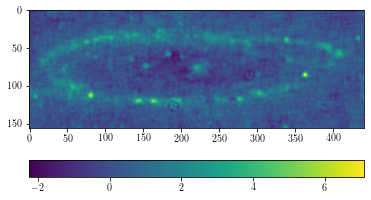

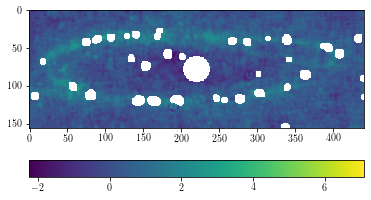

In [9]:
th_min = th_mask
th_max = np.pi
th_range_in = [th_min, th_max]
this_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, rl=rl_mask)
ma_data= ma.array(data, mask=np.logical_not(this_mask))
minmin = np.min(data)
maxmax = np.max(data)
fig = plt.figure()
plt.imshow(data, vmin=minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/real_data.pdf')
fig = plt.figure()
plt.imshow(ma_data, vmin=minmin, vmax=maxmax)
plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/ps_center_masked_data.pdf')

[0.0e+00 1.0e+00 4.0e+00 1.5e-02 3.0e-03]
initial weights are: w0 = 0.0; w1 = 1.0; w2 = 4.0; w3 = 0.015; w4 = 0.003; 
chi^2 = 214702.81527259506
w_fin:  [-1.37722367e-01  1.11281542e+00  4.20050018e+00  1.41995042e-02
  3.70670747e-03]
True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
final chi2: 187455.5102155168


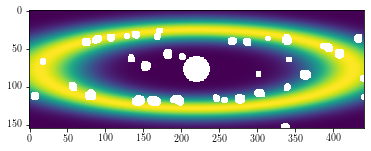

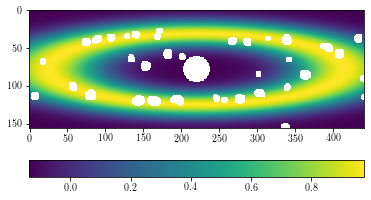

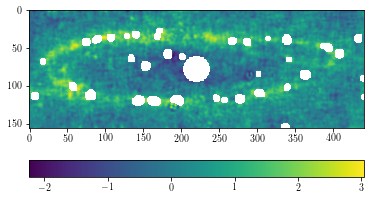

In [10]:
w_init = np.array([0,  1,  4,  0.015, 3e-3])
print(w_init)
plt.imshow(ma.array(f([AX_N, AX_n], w_init), mask=np.logical_not(this_mask)))

#print initial statistics
this_chi2 = chi2(w_init, *(data, [AX_N, AX_n],  noise, this_mask))
statement1 = 'initial weights are: '
for j in range(len(w_init)):
    statement1 += 'w' + str(j) + ' = ' + str(w_init[j]) + '; '
print(statement1)
print('chi^2 = ' + str(this_chi2))

# update weights
bnds = [(-1, 1), (0, 2), (3, 5), (.01 , 0.02), (1e-3, 1e-2)]
res = minimize(chi2, w_init, args=(data, [AX_N, AX_n], noise, this_mask), bounds=bnds)

w_fin = res.x
print('w_fin: ', w_fin)
print(res.success)
print(res.message)
chi2_final = chi2(w_fin, *(data, [AX_N, AX_n], noise, this_mask))
print('final chi2: '+ str(chi2_final)) 
fig = plt.figure()
new_model = f([AX_N, AX_n], w_fin)
plt.imshow(ma.array(new_model, mask=np.logical_not(this_mask))) 
plt.colorbar(orientation='horizontal')
#plt.savefig(base_path+'figs/best_ring_model_masked.pdf')
fig = plt.figure()
plt.imshow(ma_data)
plt.colorbar(orientation='horizontal')

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--ss', help='starting sample (the initial sample number of the run)', type=int)
parser.add_argument('--mode', help='options are save, load, and none', type=str)
parser.add_argument('--num_samples', help='this will be the number of samples generated in this script', type=int)
parser.add_argument('--ellipse_params', help='these are the parameters of the ellipse of best fit ordered as \
[w_r, r, a, sigma_a]', nargs='+', type=float)
args = parser.parse_args()

#make them local variables                                                                                           
mode = args.mode
starting_sample = args.ss
num_samples = args.num_samples
ell_params = args.ellipse_params

In [11]:
mode = 'load'
starting_sample1 = 0
starting_sample2 = 1000
starting_samples= tuple((starting_sample1, starting_sample2))
type1 = 'noring'
type2 = 'ring'
types = tuple((type1, type2))
num_samples = 200
ell_params = w_fin[1:].copy()

In [78]:
a0 = np.random.rand(6,7)
mask = np.array([True, False, True])
a1 = np.ones((3, 6, 7))
a1*a0

array([[[0.36885051, 0.85015588, 0.15143572, 0.34341574, 0.61698358,
         0.49861457, 0.06257371],
        [0.45629979, 0.90768115, 0.00505324, 0.93395224, 0.78655982,
         0.03506602, 0.83599607],
        [0.62146381, 0.29002716, 0.44273633, 0.13114938, 0.7600308 ,
         0.79925945, 0.628041  ],
        [0.18912698, 0.00959867, 0.08190879, 0.33615494, 0.12489961,
         0.68315905, 0.87352699],
        [0.30073525, 0.43772492, 0.11575461, 0.83417309, 0.29438047,
         0.17887125, 0.85051775],
        [0.68685437, 0.94133398, 0.51089789, 0.3033014 , 0.64703399,
         0.30240278, 0.61303787]],

       [[0.36885051, 0.85015588, 0.15143572, 0.34341574, 0.61698358,
         0.49861457, 0.06257371],
        [0.45629979, 0.90768115, 0.00505324, 0.93395224, 0.78655982,
         0.03506602, 0.83599607],
        [0.62146381, 0.29002716, 0.44273633, 0.13114938, 0.7600308 ,
         0.79925945, 0.628041  ],
        [0.18912698, 0.00959867, 0.08190879, 0.33615494, 0.12489961,
  

In [12]:
unit_model = f([AX_N, AX_n], [0,1]+list(w_fin[2:]))
model = f([AX_N, AX_n], [0]+list(w_fin[1:]))
unif = np.ones((n, N))
#create masks and compute quantities that depend on mask but not data
num_masks = 50
mask_set = []
mask_thicknesses = np.linspace(0, 3.5*ell_params[3], num_masks)
for thickness in mask_thicknesses:
    this_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, coords=(AX_N, AX_n), \
                            ellipse_params=[ell_params[1], ell_params[2], thickness],\
                            method='ellipse_and_azimuthally_sym', rl=rl_mask)
    mask_set.append(this_mask)
    

mask_set = np.array(mask_set)
B_set = np.sum(mask_set*(1/noise)**2, axis=(1,2))
C_set = np.sum(mask_set*(unit_model/noise**2), axis=(1,2))
E_set = np.sum(mask_set*(unit_model**2/noise**2), axis=(1,2))
frac = 2.7
beam_cut = 5

In [14]:
B_set

array([830415.55555556, 801333.77777778, 772225.33333333, 743335.55555556,
       713404.88888889, 683012.88888889, 652348.44444444, 622941.77777778,
       594147.11111111, 566182.22222222, 539023.55555556, 512069.77777778,
       485270.22222222, 458822.66666667, 432658.22222222, 406999.11111111,
       381826.22222222, 356973.77777778, 331664.88888889, 307905.77777778,
       284605.77777778, 261205.33333333, 238689.77777778, 216372.44444444,
       194264.44444444, 172893.77777778, 151387.11111111, 130507.11111111,
       110288.44444444,  91211.11111111,  76020.88888889,  62823.55555556,
        51147.11111111,  41084.44444444,  31809.77777778,  24046.22222222,
        17384.88888889,  11825.77777778,   7580.44444444,   4444.44444444])

In [13]:
#naming convention - w0: uniform background intensity; w1: ellipse intensity; 
#                    r: ring fit; n: no ring fit; 1: simulated data type 1; 
#                    2: simulated data type 2; chi2: chi^2 assuming a particular model
w0n_1 = np.zeros((num_masks, num_samples))
w0n_2 = np.zeros((num_masks, num_samples))
w0n = tuple((w0n_1, w0n_2))
w0r_1 = np.zeros((num_masks, num_samples))
w0r_2 = np.zeros((num_masks, num_samples))
w0r = tuple((w0r_1, w0r_2))
w1r_1 = np.zeros((num_masks, num_samples))
w1r_2 = np.zeros((num_masks, num_samples))
w1r = tuple((w1r_1, w1r_2))
chi2n_1 = np.zeros((num_masks, num_samples))
chi2n_2 = np.zeros((num_masks, num_samples))
chi2n = tuple((chi2n_1, chi2n_2))
chi2r_1 = np.zeros((num_masks, num_samples))
chi2r_2 = np.zeros((num_masks, num_samples))
chi2r = tuple((chi2r_1, chi2r_2))
#initialize data_resid variables
file_name_base = base_path + 'fake_resid_new/sigma_rms_'+ str(sigma_rms[0]) + '_' + str(sigma_rms[-1]) +\
    '_spacing_' + '{:.2e}'.format(dlt_N/frac) + '_samplenum_'
for i in range(num_samples+1):
    print('starting to generate sample number ' + str(i))
    #generate fake data residuals                                                                                    
    file_names = [file_name_base+str(i+ss)+'.npy' for ss in starting_samples]
    if mode == 'save' or mode == 'none':
        if i<num_samples:
            data_resid1, _, _ = gen_fake_data(beam_cut, frac, sigma_rms, sigma_BW, N, n, dlt_N, dlt_n)
            data_resid2, _, _ = gen_fake_data(beam_cut, frac, sigma_rms, sigma_BW, N, n, dlt_N, dlt_n)
            data_resids = [data_resid1, data_resid2]
            if mode == 'save':
                for file, resid in zip(file_names, data_resids):
                    np.save(file, resid)
            print('sample number '+ str(i) + ' generated')
        else:
            data_resid1 = data
            data_resid2 = data
            data_resids = [data_resid1, data_resid2]
    elif mode == 'load':
        if i<num_samples:
            data_resids = (np.load(file) for file in file_names)
        else:
            data_resid1 = data
            data_resid2 = data
            data_resids = [data_resid1, data_resid2]
    else:
        print('value mode is not recognized')
    if i<num_samples:
        fake_data = [resid if t=='noring' else resid+model for resid, t in zip(data_resids, types)]
    else:
        fake_data = data_resids
    
    A_set = [np.sum(mask_set*fdata/noise**2, axis=(1,2)) for fdata in fake_data]
    D_set = [np.sum(mask_set*fdata*unit_model/noise**2, axis=(1,2)) for fdata in fake_data]
    this_w0n = [a/B_set for a in A_set]
    this_w0r = [(d-a*E_set/C_set)/(C_set-B_set*E_set/C_set) for a, d, in zip(A_set, D_set)]
    this_w1r = [a/C_set-w*B_set/C_set for a, w in zip(A_set, this_w0r)]
    this_chi2n = [np.sum((mask_set*fdata-mask_set*np.multiply.outer(w, unif))**2/noise**2, axis=(1,2)) for fdata,w in zip(fake_data, this_w0n)]
    this_chi2r = [np.sum((mask_set*fdata-mask_set*(np.multiply.outer(w0, unif)+np.multiply.outer(w1, unit_model)))**2/noise**2, axis=(1,2)) for fdata,w0,w1 in zip(fake_data, this_w0r, this_w1r)]
    if i < num_samples:
        for k in range(len(this_chi2r)):
            w0n[k][:, i] = this_w0n[k]
            w0r[k][:, i] = this_w0r[k]
            w1r[k][:, i] = this_w1r[k]
            chi2n[k][:, i] = this_chi2n[k]
            chi2r[k][:, i] = this_chi2r[k]
    else:
        dchi2_data = this_chi2n[0]-this_chi2r[0]
dchi2 = tuple((cn-cr for cn, cr in zip(chi2n, chi2r)))

starting to generate sample number 0
starting to generate sample number 1
starting to generate sample number 2
starting to generate sample number 3
starting to generate sample number 4
starting to generate sample number 5
starting to generate sample number 6
starting to generate sample number 7
starting to generate sample number 8
starting to generate sample number 9
starting to generate sample number 10
starting to generate sample number 11
starting to generate sample number 12
starting to generate sample number 13
starting to generate sample number 14
starting to generate sample number 15
starting to generate sample number 16
starting to generate sample number 17
starting to generate sample number 18
starting to generate sample number 19
starting to generate sample number 20
starting to generate sample number 21
starting to generate sample number 22
starting to generate sample number 23
starting to generate sample number 24
starting to generate sample number 25
starting to generate s

In [15]:
#In this block, I keep the ring intensty fixed for each simulated intensity map
#naming convention - w0: uniform background intensity; w1: ellipse intensity; 
#                    r: ring fit; n: no ring fit; 1: simulated data type 1; 
#                    2: simulated data type 2; chi2: chi^2 assuming a particular model
w0n_1 = np.zeros((num_masks, num_samples))
w0n_2 = np.zeros((num_masks, num_samples))
w0n = tuple((w0n_1, w0n_2))
w0r_1 = np.zeros((num_masks, num_samples))
w0r_2 = np.zeros((num_masks, num_samples))
w0r = tuple((w0r_1, w0r_2))
w1r_1 = np.zeros((num_masks, num_samples))
w1r_2 = np.zeros((num_masks, num_samples))
w1r = tuple((w1r_1, w1r_2))
chi2n_1 = np.zeros((num_masks, num_samples))
chi2n_2 = np.zeros((num_masks, num_samples))
chi2n = tuple((chi2n_1, chi2n_2))
chi2r_1 = np.zeros((num_masks, num_samples))
chi2r_2 = np.zeros((num_masks, num_samples))
chi2r = tuple((chi2r_1, chi2r_2))
#initialize data_resid variables
file_name_base = base_path + 'fake_resid_new/sigma_rms_'+ str(sigma_rms[0]) + '_' + str(sigma_rms[-1]) +\
    '_spacing_' + '{:.2e}'.format(dlt_N/frac) + '_samplenum_'
for i in range(num_samples+1):
    print('starting to generate sample number ' + str(i))
    #generate fake data residuals                                                                                    
    file_names = [file_name_base+str(i+ss)+'.npy' for ss in starting_samples]
    if mode == 'save' or mode == 'none':
        if i<num_samples:
            data_resid1, _, _ = gen_fake_data(beam_cut, frac, sigma_rms, sigma_BW, N, n, dlt_N, dlt_n)
            data_resid2, _, _ = gen_fake_data(beam_cut, frac, sigma_rms, sigma_BW, N, n, dlt_N, dlt_n)
            data_resids = [data_resid1, data_resid2]
            if mode == 'save':
                for file, resid in zip(file_names, data_resids):
                    np.save(file, resid)
            print('sample number '+ str(i) + ' generated')
        else:
            data_resid1 = data
            data_resid2 = data
            data_resids = [data_resid1, data_resid2]
    elif mode == 'load':
        if i<num_samples:
            data_resids = (np.load(file) for file in file_names)
        else:
            data_resid1 = data
            data_resid2 = data
            data_resids = [data_resid1, data_resid2]
    else:
        print('value mode is not recognized')
    if i<num_samples:
        fake_data = [resid if t=='noring' else resid+model for resid, t in zip(data_resids, types)]
    else:
        fake_data = data_resids
    
    A_set = [np.sum(mask_set*fdata/noise**2, axis=(1,2)) for fdata in fake_data]

    this_w0n = [a/B_set for a in A_set]
    this_w0r = [(a-w_fin[1]*C_set)/B_set for a in A_set]
    this_chi2n = [np.sum((mask_set*fdata-mask_set*np.multiply.outer(w, unif))**2/noise**2, axis=(1,2)) for fdata,w in zip(fake_data, this_w0n)]
    this_chi2r = [np.sum((mask_set*(fdata-w_fin[1]*unit_model)-mask_set*np.multiply.outer(w0, unif))**2/noise**2, axis=(1,2)) for fdata,w0 in zip(fake_data, this_w0r)]
    if i < num_samples:
        for k in range(len(this_chi2r)):
            w0n[k][:, i] = this_w0n[k]
            w0r[k][:, i] = this_w0r[k]
            chi2n[k][:, i] = this_chi2n[k]
            chi2r[k][:, i] = this_chi2r[k]
    else:
        dchi2_data = this_chi2n[0]-this_chi2r[0]
dchi2 = tuple((cn-cr for cn, cr in zip(chi2n, chi2r)))

starting to generate sample number 0
starting to generate sample number 1
starting to generate sample number 2
starting to generate sample number 3
starting to generate sample number 4
starting to generate sample number 5
starting to generate sample number 6
starting to generate sample number 7
starting to generate sample number 8
starting to generate sample number 9
starting to generate sample number 10
starting to generate sample number 11
starting to generate sample number 12
starting to generate sample number 13
starting to generate sample number 14
starting to generate sample number 15
starting to generate sample number 16
starting to generate sample number 17
starting to generate sample number 18
starting to generate sample number 19
starting to generate sample number 20
starting to generate sample number 21
starting to generate sample number 22
starting to generate sample number 23
starting to generate sample number 24
starting to generate sample number 25
starting to generate s

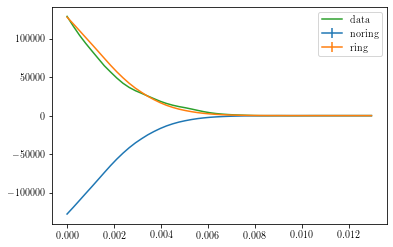

In [23]:
mean_dchi2 = tuple((np.mean(dist, axis=-1) for dist in dchi2))
std_dchi2 = tuple((np.std(dist, axis=-1) for dist in dchi2))
mean_dchi2[0].shape
plt.errorbar(mask_thicknesses, mean_dchi2[0], yerr=std_dchi2[0]/np.sqrt(num_samples), label=types[0])
plt.errorbar(mask_thicknesses, mean_dchi2[1], yerr=std_dchi2[1]/np.sqrt(num_samples), label=types[1])
plt.plot(mask_thicknesses, dchi2_data, label='data')
#plt.yscale('log')
plt.legend()

In [29]:
std_dchi2[0]

array([6.29282440e+03, 5.86381220e+03, 5.48221279e+03, 5.17397949e+03,
       4.93680339e+03, 4.70675924e+03, 4.46963130e+03, 4.23023722e+03,
       3.95345783e+03, 3.66797979e+03, 3.39159507e+03, 3.11183600e+03,
       2.85588670e+03, 2.59062669e+03, 2.32274955e+03, 2.04468729e+03,
       1.80660588e+03, 1.60901844e+03, 1.41198715e+03, 1.22676721e+03,
       1.05590304e+03, 9.08661310e+02, 7.81121067e+02, 6.63915622e+02,
       5.60917473e+02, 4.67852526e+02, 3.83740967e+02, 3.13835687e+02,
       2.59853246e+02, 2.17707610e+02, 1.81630290e+02, 1.48835483e+02,
       1.20896366e+02, 9.77365916e+01, 7.80735798e+01, 5.97816410e+01,
       4.40956350e+01, 3.23962634e+01, 2.31544461e+01, 1.67266176e+01,
       1.19065531e+01, 8.42015810e+00, 5.89150820e+00, 3.91695153e+00,
       2.58345779e+00, 1.63679963e+00, 1.03974815e+00, 6.30143696e-01,
       3.37662881e-01, 1.68300202e-01])

In [17]:
print('w0n')
mean_w0n = [np.mean(w, axis=-1) for w in w0n]
print(types[0], mean_w0n[0])
print(types[1], mean_w0n[1])
print('w0r')
mean_w0r = [np.mean(w, axis=-1) for w in w0r]
print(types[0], mean_w0r[0])
print(types[1], mean_w0r[1])
print('w1r')
mean_w1r = [np.mean(w, axis=-1) for w in w1r]
print(types[0], mean_w1r[0])
print(types[1], mean_w1r[1])
print('chi2 for no ring fit')
mean_chi2n = [np.mean(chi, axis=-1) for chi in chi2n]
print(types[0], mean_chi2n[0])
print(types[1], mean_chi2n[1])
print('chi2 for ring fit')
mean_chi2r = [np.mean(chi, axis=-1) for chi in chi2r]
print(types[0], mean_chi2r[0])
print(types[1], mean_chi2r[1])

w0n
noring [ 3.85720627e-04  4.35272327e-04  5.29994369e-04  5.95872161e-04
  6.05082036e-04  5.85640088e-04  5.36700166e-04  4.48232685e-04
  3.51022773e-04  2.43848131e-04  1.57888718e-04  1.19479817e-04
  8.70067963e-05  2.15520116e-05 -6.34878303e-05 -1.48907983e-04
 -2.22942813e-04 -2.79718670e-04 -3.50030872e-04 -4.61449330e-04
 -4.99185387e-04 -5.27219630e-04 -5.93745957e-04 -7.48912741e-04
 -8.95809689e-04 -9.48934240e-04 -9.42386202e-04 -8.55359555e-04
 -6.94031674e-04 -4.58071011e-04 -1.69253251e-04  6.85116947e-05
  2.08204147e-04  3.14058269e-04  2.30808029e-04  2.57497942e-04
  2.59279126e-04  1.29161999e-04 -1.74214276e-04 -5.43273297e-04
 -6.31674212e-04 -7.67986983e-04 -9.64703742e-04 -1.21521104e-03
 -1.83942293e-03 -2.69400980e-03 -3.45064428e-03 -3.92814087e-03
 -5.89087271e-03 -9.87438707e-03]
ring [ 5.15394548e-01  4.97885471e-01  4.79770067e-01  4.61113938e-01
  4.42121997e-01  4.22082393e-01  4.01034695e-01  3.79124696e-01
  3.57302482e-01  3.35813900e-01  3.1466

In [20]:
#option to load dchi distribution statistics instead of using the stats computed in this notebook
#dchi2_nr = np.load(base_path+'results_compare_rvnr/dchi2_noring_'+ rl_mask+'.npy')
#dchi2_r = np.load(base_path+'results_compare_rvnr/dchi2_ring_'+rl_mask+'.npy')
dchi2_mean_nr = np.load(base_path+'results_compare_rvnr/dchi2_mean_noring'+rl_mask+'_.npy')
dchi2_mean_r = np.load(base_path+'results_compare_rvnr/dchi2_mean_ring'+rl_mask+'_.npy')
dchi2_std_nr = np.load(base_path+'results_compare_rvnr/dchi2_mean_noring'+rl_mask+'_.npy')
dchi2_std_r = np.load(base_path+'results_compare_rvnr/dchi2_mean_ring'+rl_mask+'_.npy')
mask_thick_ld = np.load(base_path+'results_compare_rvnr/maskthicknesses'+rl_mask+'_.npy')
print(dchi2_mean_nr.shape)
print(dchi2_mean_r.shape)
print(dchi2_std_nr.shape)
print(dchi2_std_r.shape)
print(mask_thick_ld.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/het/p4/mjw283/eventgen_wd/Secondary_radiation/results_compare_rvnr/dchi2_mean_noring_.npy'

In [18]:
n_pix = np.sum(mask_set, axis=(1,2))
print(n_pix.shape)

(50,)


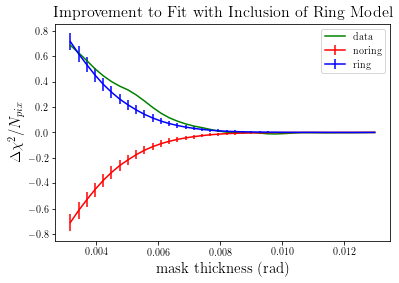

In [40]:
#mean_dchi2 = (dchi2_mean_nr, dchi2_mean_r)
#std_dchi2 = (dchi2_std_nr, dchi2_std_r)
mask_thick_ld = mask_thicknesses
num_samples = 200
st_ind = 12
plt.errorbar(mask_thick_ld[st_ind:], mean_dchi2[0][st_ind:]/n_pix[st_ind:], yerr=(1/n_pix[st_ind:])*std_dchi2[0][st_ind:], label=types[0], color='r')
plt.errorbar(mask_thick_ld[st_ind:], mean_dchi2[1][st_ind:]/n_pix[st_ind:], yerr=(1/n_pix[st_ind:])*std_dchi2[1][st_ind:], label=types[1], color='b')
plt.plot(mask_thick_ld[st_ind:], (1/n_pix[st_ind:])*dchi2_data[st_ind:], label='data', color='g')
plt.xlabel(r'mask thickness ' + r'$\rm{(rad)}$', size=15)
plt.ylabel(r'$\Delta \chi^2/N_{pix}$', size=15)
plt.title(r'Improvement to Fit with Inclusion of Ring Model', size=16)
#plt.yscale('log')
plt.legend()
#plt.savefig(base_path+'results_compare_rvnr/Improvement_to_fit_dchi2.pdf')

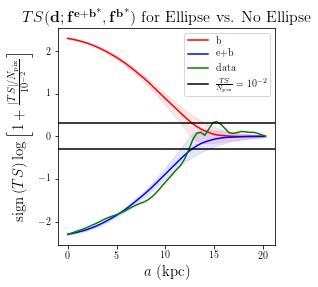

In [72]:
p = -2
a = 2*780*mask_thicknesses
plt.plot(a, np.sign(-mean_dchi2[0])*(np.log10(1+np.abs(mean_dchi2[0]/n_pix)/10**p)), label='b', color='r')
plt.plot(a, np.sign(-mean_dchi2[1])*(np.log10(1+np.abs(mean_dchi2[1]/n_pix)/10**p)), label='e+b', color='b')
plt.plot(a, np.sign(-dchi2_data)*(np.log10(1+np.abs(dchi2_data/n_pix)/10**p)), label='data', color='g')
noring_lower = np.sign(-(mean_dchi2[0]-std_dchi2[0]))*(np.log10(1+np.abs((mean_dchi2[0]-std_dchi2[0])/n_pix)/10**p))
noring_upper = np.sign(-(mean_dchi2[0]+std_dchi2[0]))*(np.log10(1+np.abs((mean_dchi2[0]+std_dchi2[0])/n_pix)/10**p))
plt.fill_between(a, noring_lower, noring_upper, color='r', alpha=0.1, label='_nolegend_')
ring_lower = np.sign(-(mean_dchi2[1]-std_dchi2[1]))*(np.log10(1+np.abs((mean_dchi2[1]-std_dchi2[1])/n_pix)/10**p))
ring_upper = np.sign(-(mean_dchi2[1]+std_dchi2[1]))*(np.log10(1+np.abs((mean_dchi2[1]+std_dchi2[1])/n_pix)/10**p))
plt.fill_between(a, ring_lower, ring_upper, color='b', alpha=0.1, label='_nolegend_')
plt.axhline(y = np.log10(2), color = 'k', linestyle = '-', label=r'$\frac{TS}{N_{\rm pix}} =  10^{-2}$')
plt.axhline(y = -np.log10(2), color = 'k', linestyle = '-')
plt.xlabel(r'$a \; \rm{(kpc)}$', size=15)
plt.ylabel(r'$\mathrm{sign}\left(TS\right)\log{\left[1+\frac{\left|TS\right|/N_{\rm pix}}{10^{-2}}\right]}$', size=15)
plt.title(r'$TS(\mathbf{d}; \mathbf{{f^{e+b}}^*}, \mathbf{{f^{b}}^*})$  for Ellipse vs. No Ellipse', size=16)
plt.legend()
ax = plt.gca()
ax.set_box_aspect(1)
plt.savefig(fig_path+'/Improvement_to_fit_dchi2.pdf')

[0.         0.00026476 0.00052953 0.00079429 0.00105906 0.00132382
 0.00158859 0.00185335 0.00211812 0.00238288 0.00264765 0.00291241
 0.00317718 0.00344194 0.00370671 0.00397147 0.00423624 0.004501
 0.00476577 0.00503053 0.0052953  0.00556006 0.00582483 0.00608959
 0.00635436 0.00661912 0.00688389 0.00714865 0.00741341 0.00767818
 0.00794294 0.00820771 0.00847247 0.00873724 0.009002   0.00926677
 0.00953153 0.0097963  0.01006106 0.01032583 0.01059059 0.01085536
 0.01112012 0.01138489 0.01164965 0.01191442 0.01217918 0.01244395
 0.01270871 0.01297348]
[0.         0.00026476 0.00052953 0.00079429 0.00105906 0.00132382
 0.00158859 0.00185335 0.00211812 0.00238288 0.00264765 0.00291241
 0.00317718 0.00344194 0.00370671 0.00397147 0.00423624 0.004501
 0.00476577 0.00503053 0.0052953  0.00556006 0.00582483 0.00608959
 0.00635436 0.00661912 0.00688389 0.00714865 0.00741341 0.00767818
 0.00794294 0.00820771 0.00847247 0.00873724 0.009002   0.00926677
 0.00953153 0.0097963  0.01006106 0.010325

In [37]:
print(diff)

[ 6.02370140e+02 -3.33604129e+03 -6.20804342e+03 -7.74859780e+03
 -8.63444590e+03 -9.11188495e+03 -9.49767740e+03 -8.50913842e+03
 -7.78998588e+03 -6.85320151e+03 -5.23641888e+03 -3.28100991e+03
 -1.25870200e+03  2.37791440e+02  1.18633049e+03  1.76547975e+03
  2.37759981e+03  2.93043086e+03  3.54044625e+03  4.06148665e+03
  4.00855239e+03  3.44710617e+03  2.58209474e+03  1.80668694e+03
  1.22523533e+03  8.52488203e+02  5.69767519e+02  3.55843604e+02
  2.38292163e+02  6.22417370e+01 -7.76755048e+01 -1.26744498e+02
 -1.16258361e+02 -9.17599081e+01 -6.74870065e+01 -5.35446474e+01
  4.82428588e+01  1.33013379e+02  9.48827889e+01  2.25288095e+01
 -1.88836435e+01 -1.76593201e+01  1.04930346e+00  4.21331985e+01
  5.17337943e+01  5.27638619e+01  8.15940323e+01  5.56636751e+01
  1.34030162e+01 -6.34686249e+00]


In [76]:
diff = dchi2_data-mean_dchi2[1]
diff_nr = dchi2_data-mean_dchi2[0]
diff_interp = interpolate.interp1d(mask_thicknesses, diff, kind='cubic')
diff_nr_interp = interpolate.interp1d(mask_thicknesses, diff_nr, kind='cubic')
t4 = fsolve(diff_interp, 0.008)[0]
print(2*t4*780)

12.2824724207636


In [74]:
mask_sizes = [t1, t2, t3, t4]

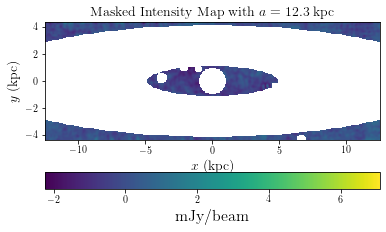

In [79]:
DA=780
this_mask = create_mask(THETA, th_range_in, ps_ind=mask_inds, coords=(AX_N, AX_n), \
                            ellipse_params=[ell_params[1], ell_params[2], t4],\
                            method='ellipse_and_azimuthally_sym', rl=rl_mask)
ma_data= ma.array(data, mask=np.logical_not(this_mask))
minmin = np.min(data)
maxmax = np.max(data)
fig = plt.figure()
plt.imshow(ma_data, extent=[ax_N[0]*DA, ax_N[-1]*DA, ax_n[0]*DA, ax_n[-1]*DA], vmin=minmin, vmax=maxmax)
plt.xlabel(r'$x \; \rm{(kpc)}$', size=14)
plt.ylabel(r'$y \; \rm{(kpc)}$', size=14)
plt.title(r'Masked Intensity Map with $a = 12.3\;\rm{kpc}$', size=14)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$\rm{mJy/beam}$', size=16)
plt.savefig(base_path+'figs/masked.pdf')